In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
import pyproj
import datetime
import math
from sklearn.decomposition import PCA
import seaborn as sns; sns.set_theme()

In [2]:
filename = 'huston only.csv'
filepath = '/Users/ljw7696/Desktop/UCB/MS CEE SYS/(2) 2022 Spring/CE 290-002/Project/bad weather/TX Only/'+filename
df_raw = pd.read_csv(filepath)

#print(df_raw.columns)
df_raw.head()

/var/folders/kr/b2gw9rks019_nsx6dsjpt98m0000gn/T/ipykernel_10381/51270306.py:3: DtypeWarning: Columns (2,4,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,122,124,125,126,127,129,131,132,134,135) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv(filepath)


,STATION,DATE,SOURCE,REPORT_TYPE,CALL_SIGN,QUALITY_CONTROL,AA1,AA2,AA3,AA4,...,SA1,SLP,SOURCE.1,TMP,UA1,UG1,VIS,WA1,WG1,WND
0,94999900223,1964-12-31T23:00:00,N,AUST,,V020,NaN,NaN,NaN,NaN,...,NaN,"99999,9",N,"+0228,5",NaN,NaN,"999999,9,9,9",NaN,NaN,"113,5,N,0005,5"
1,94999900223,1965-01-01T23:00:00,N,AUST,,V020,NaN,NaN,NaN,NaN,...,NaN,"99999,9",N,"+0272,5",NaN,NaN,"999999,9,9,9",NaN,NaN,"090,5,N,0010,5"
2,94999900223,1965-01-02T23:00:00,N,AUST,,V020,NaN,NaN,NaN,NaN,...,NaN,"99999,9",N,"+0229,5",NaN,NaN,"999999,9,9,9",NaN,NaN,"135,5,N,0036,5"
3,94999900223,1965-01-03T23:00:00,N,AUST,,V020,NaN,NaN,NaN,NaN,...,NaN,"99999,9",N,"+0211,5",NaN,NaN,"999999,9,9,9",NaN,NaN,"135,5,N,0015,5"
4,94999900223,1965-01-04T23:00:00,N,AUST,,V020,NaN,NaN,NaN,NaN,...,NaN,"99999,9",N,"+0199,5",NaN,NaN,"999999,9,9,9",NaN,NaN,"248,5,N,0010,5"


In [3]:
df_raw.shape

(4105808, 137)

In [4]:
# df_raw2 = df_raw[:100000].copy()
df_raw2 = df_raw.copy()

## old

In [5]:
def ParseDF(df):
    # Select columns we care
    
    # PARSE
    # Split DATE
    datetime = pd.to_datetime(df['DATE'])
    df['DATE_year'] = datetime.dt.year
    df['DATE_month'] = datetime.dt.month
    df['DATE_day'] = datetime.dt.day
    df['DATE_hour'] = datetime.dt.hour
    
    columns_parse = ['WND','CIG','VIS','TMP','DEW']
    # Split Wind WND data
    df[['WND_angle','WND_angle_quality','WND_wind_observation','WND_speed','WND_speed_quality']] = df.WND.str.split(',', expand=True)
    # Split CIG data
    df[['CIG_ceiling_height', 'CIG_ceiling_quality','CIG_determ', 'CIG_CAVOK']] = df.CIG.str.split(',', expand=True)
    # Split VIS data
    df[['VIS_distance','VIS_distance_quality', 'VIS_observation','VIS_observation_quality']] = df.VIS.str.split(',', expand=True)
    # Split TMP data
    df[['TMP_temp_celsius','TMP_temp_quality']] = df.TMP.str.split(',', expand=True)
    # SPlit DEW data
    df[['DEW_temp_celsius','DEW_quality']] = df.DEW.str.split(',', expand=True)
    # Split SLP data
    df[['SLP_hectopascal','SLP_quality']] = df.SLP.str.split(',', expand=True)
    
    def getAT(input):
        #print(type(input))
        # individual data look like: "AU,13,BR ,5", or "none"
        if type(input) == str:
            try:
                return int(input.split(',')[1])
            except:
                return 0
        else:
            return 0
    
    def AT_check(array, check=3):
        if check in array:
            return 1
        else:
            return 0
    def checkBadWeather(row):
        return 1 if np.sum(row)>0 else 0
    
    # AT
    # df['AT1'] = df['AT1'].apply(getAT)
    # df['AT2'] = df['AT2'].apply(getAT)
    # df['AT3'] = df['AT3'].apply(getAT)
    # df['AT4'] = df['AT4'].apply(getAT)
    # df['AT'] = list(df[['AT1','AT2','AT3','AT4']].to_numpy())
    # df['AT'] = list(df['AT1'].to_numpy())
    # df['AT_binary'] = df['AT'].apply(checkBadWeather)
    # df['AT_thunder'] = df['AT'].copy()
    # df['AT_thunder'] = df['AT_thunder'].apply(AT_check)

    # Drop parsed raw data
    df.drop(columns_parse, axis=1, inplace=True)
    return df

def KeepRelevant(df):
    columns = ['STATION', 'DATE','DATE_year','DATE_month','DATE_day','DATE_hour', 'WND_angle', 
               'WND_speed', 'CIG_ceiling_height', 'VIS_distance', 'TMP_temp_celsius', 'DEW_temp_celsius',
               'SLP_hectopascal','AT1', 'AT2', 'AT3', 'AT4']
    df = df[columns]
    return df

def ReplaceMissingNumericWithNeighbor(df, column, to_replace=[999,9999,99999,999999], value=np.nan, rescale=1):
    '''Replace Missing values with NaN, Fill with method='ffill'''
    df[column] = df[column].astype(int)
    df[column].replace(to_replace=to_replace, value=np.nan, inplace=True)
    # Fill NaN
    df[column] = df[column].fillna(method='ffill')
    df[column] = df[column].fillna(method='bfill')
    
    if rescale != 1:
        df[column] = df[column]/rescale
        
    return df


def DataframePreprocessingPipeline(df):
    # Parse
    df = ParseDF(df)
    df = KeepRelevant(df)
    
    # Replace & Rescale
    df = ReplaceMissingNumericWithNeighbor(df, 'WND_angle')
    df = ReplaceMissingNumericWithNeighbor(df, 'WND_speed', rescale=10)
    df = ReplaceMissingNumericWithNeighbor(df, 'CIG_ceiling_height')
    df = ReplaceMissingNumericWithNeighbor(df, 'VIS_distance')
    df = ReplaceMissingNumericWithNeighbor(df, 'TMP_temp_celsius',rescale=10)
    df = ReplaceMissingNumericWithNeighbor(df, 'DEW_temp_celsius', rescale=10)
    df = ReplaceMissingNumericWithNeighbor(df, 'SLP_hectopascal', rescale=10)
    
    # df = Fill_thunder_day(df)
    # df = Fill_AT_binary_day(df)
    
    return df

df = DataframePreprocessingPipeline(df_raw2)

/var/folders/kr/b2gw9rks019_nsx6dsjpt98m0000gn/T/ipykernel_10381/2105686998.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].astype(int)
/var/folders/kr/b2gw9rks019_nsx6dsjpt98m0000gn/T/ipykernel_10381/2105686998.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column].replace(to_replace=to_replace, value=np.nan, inplace=True)
/var/folders/kr/b2gw9rks019_nsx6dsjpt98m0000gn/T/ipykernel_10381/2105686998.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

In [6]:
df_new = df.copy()

In [7]:
def uniqueElementList(list1):
    x = np.array(list1)
    # print(np.unique(x))
    return np.unique(x)


def uniqueElementPd(df):
    return list(pd.unique(df))

df_new
# df.shape

,STATION,DATE,DATE_year,DATE_month,DATE_day,DATE_hour,WND_angle,WND_speed,CIG_ceiling_height,VIS_distance,TMP_temp_celsius,DEW_temp_celsius,SLP_hectopascal,AT1,AT2,AT3,AT4
0,94999900223,1964-12-31T23:00:00,1964,12,31,23,113.0,0.5,22000.0,2816.0,22.8,11.0,1021.7,NaN,NaN,NaN,NaN
1,94999900223,1965-01-01T23:00:00,1965,1,1,23,90.0,1.0,22000.0,2816.0,27.2,14.0,1021.7,NaN,NaN,NaN,NaN
2,94999900223,1965-01-02T23:00:00,1965,1,2,23,135.0,3.6,22000.0,2816.0,22.9,13.0,1021.7,NaN,NaN,NaN,NaN
3,94999900223,1965-01-03T23:00:00,1965,1,3,23,135.0,1.5,22000.0,2816.0,21.1,12.0,1021.7,NaN,NaN,NaN,NaN
4,94999900223,1965-01-04T23:00:00,1965,1,4,23,248.0,1.0,22000.0,2816.0,19.9,16.0,1021.7,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4105803,72243599999,1969-12-31T15:00:00,1969,12,31,15,320.0,2.1,22000.0,11200.0,0.2,-1.5,1023.9,NaN,NaN,NaN,NaN
4105804,72243599999,1969-12-31T18:00:00,1969,12,31,18,330.0,3.6,3600.0,12800.0,4.6,-2.0,1022.8,NaN,NaN,NaN,NaN
4105805,72243599999,1969-12-31T21:00:00,1969,12,31,21,330.0,3.1,2100.0,16000.0,7.4,-3.7,1021.0,NaN,NaN,NaN,NaN
4105806,72243599999,1970-01-01T00:00:00,1970,1,1,0,320.0,2.1,2100.0,19200.0,6.3,-3.1,1021.9,NaN,NaN,NaN,NaN


In [8]:
df_new = df_new[df_new['DATE_year'] >= 1980]

In [9]:
# df_new[df_new['AX1'] == 0]


In [10]:
# temp = df_new[(df_new['DATE_year'] == 1981) & (df_new['DATE_month'] == 1) & (df_new['DATE_day'] == 1)].sort_values(by=['DATE_year', 'DATE_month', 'DATE_day', 'DATE_hour']).copy()

# temp = temp.drop_duplicates(subset=['DATE_year', 'DATE_month', 'DATE_day', 'DATE_hour'])

# print(np.shape(temp))

In [11]:
print(np.shape(df_new))

(3310223, 17)


In [12]:
temp = df_new.copy()

df_new['AT1'].value_counts()

# temp['DATE_day']

AU,16,RA  ,5    7332
AU,03,TS  ,5    6709
AU,13,BR  ,5    5496
AU,01,FG  ,5    2733
MW,03,TS  ,1    1218
MW,01,FG  ,5    1132
MW,16,RA  ,1    1019
AU,08,HZ  ,5     716
MW,16,RA  ,5     659
MW,13,BR  ,1     553
MW,03,TS  ,5     474
MW,01,FG  ,1     472
AU,21,MIFG,5     456
AW,13,BR  ,1     444
AW,16,RA  ,1     431
AW,01,FG  ,1     390
AW,03,TS  ,1     298
AU,14,DZ  ,5     151
MW,08,HZ  ,1     107
AU,03,TS  ,U      85
MW,14,DZ  ,1      85
AU,01,FG  ,A      41
AW,14,DZ  ,1      41
AU,16,RA  ,A      37
MW,14,DZ  ,5      33
MW,08,HZ  ,5      33
AW,08,HZ  ,1      28
AW,03,TS  ,5      17
AU,18,SN  ,5      15
AU,03,TS  ,A      12
AU,21,MIFG,A      12
AU,17,FZRA,5      11
AU,13,BR  ,A      10
AU,03,TS  ,P       6
AU,14,DZ  ,A       6
AU,16,RA  ,U       5
MW,10,FC  ,1       4
AU,22,FZFG,5       3
AU,10,FC  ,5       3
AU,07,DU  ,5       2
MW,18,SN  ,1       2
AU,15,FZDZ,5       2
MW,07,DU  ,1       2
AU,19,UP  ,5       2
AU,04,PL  ,5       1
AU,05,GR  ,5       1
AU,13,BR  ,U       1
AU,01,FG  ,U 

In [13]:
temp = df_new.copy()

temp['AT1'] = temp.AT1.str[6:10]
temp['AT1'] = temp['AT1'].str.strip()

print('\nbefore reset_index', temp.head())

temp.reset_index(drop=True, inplace=True)

print('\nafter reset_index', temp.head())

idx = temp[temp['AT1'] == 'RA'].index

print(idx)

# print(np.shape(temp))
temp.sort_values(by=['DATE_year', 'DATE_month', 'DATE_day', 'DATE_hour'])
# idx


before reset_index           STATION                 DATE  DATE_year  DATE_month  DATE_day  \
6500  94999900223  1981-01-01T22:00:00       1981           1         1   
6501  94999900223  1981-01-02T04:00:00       1981           1         2   
6502  94999900223  1981-01-02T22:00:00       1981           1         2   
6503  94999900223  1981-01-03T22:00:00       1981           1         3   
6504  94999900223  1981-01-04T22:00:00       1981           1         4   

      DATE_hour  WND_angle  WND_speed  CIG_ceiling_height  VIS_distance  \
6500         22       90.0        1.5             22000.0        2816.0   
6501          4      113.0        5.1             22000.0        2816.0   
6502         22      338.0        1.0             22000.0        2816.0   
6503         22      315.0        1.5             22000.0        2816.0   
6504         22       90.0        2.1             22000.0        2816.0   

      TMP_temp_celsius  DEW_temp_celsius  SLP_hectopascal  AT1  AT2  AT3  AT4 

,STATION,DATE,DATE_year,DATE_month,DATE_day,DATE_hour,WND_angle,WND_speed,CIG_ceiling_height,VIS_distance,TMP_temp_celsius,DEW_temp_celsius,SLP_hectopascal,AT1,AT2,AT3,AT4
1290068,72243612906,1980-01-01T00:00:00,1980,1,1,0,320.0,2.0,22000.0,32000.0,10.6,0.6,1021.4,NaN,NaN,NaN,NaN
1608182,72243012960,1980-01-01T00:00:00,1980,1,1,0,320.0,2.1,22000.0,24000.0,7.8,1.1,1021.5,NaN,NaN,NaN,NaN
2355245,72243512918,1980-01-01T00:00:00,1980,1,1,0,320.0,4.1,22000.0,24000.0,9.4,-1.0,1053.2,NaN,NaN,NaN,NaN
1290069,72243612906,1980-01-01T01:00:00,1980,1,1,1,260.0,2.0,22000.0,48000.0,9.4,0.6,1021.4,NaN,NaN,NaN,NaN
1608183,72243012960,1980-01-01T01:00:00,1980,1,1,1,290.0,1.5,22000.0,24000.0,4.4,2.2,1022.2,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3146325,72059400188,2022-04-17T08:35:00,2022,4,17,8,150.0,4.6,213.0,4023.0,22.0,22.0,1011.2,NaN,NaN,NaN,NaN
3146326,72059400188,2022-04-17T08:55:00,2022,4,17,8,150.0,5.1,213.0,4023.0,22.0,22.0,1011.2,NaN,NaN,NaN,NaN
502279,72242712975,2022-04-18T05:59:00,2022,4,18,5,150.0,3.6,183.0,11265.0,22.8,21.7,1012.4,BR,NaN,NaN,NaN
839013,72063700223,2022-04-18T05:59:00,2022,4,18,5,170.0,1.5,91.0,6437.0,22.0,21.2,1008.4,FG,"AU,13,BR ,5",NaN,NaN


In [14]:
temp = df_new.copy()
temp.reset_index(drop=True, inplace=True)
print(np.shape(temp))

temp['AT1'] = temp.AT1.str[6:10]
temp['AT1'] = temp['AT1'].str.strip()


idx = temp[temp['AT1'] == 'RA'].index

print(np.shape(idx))

print(type(temp['AX1'].iloc[1014456])==float)
print(type(temp['AX1'].iloc[1014454])==float)

print(temp.AX1.iloc[1014454])
print(temp.iloc[1014456].AX1)
print(temp.iloc[1014456].AX1[5:7])
print(temp.iloc[1014456].AX1[0:2])

## take hour
# for i in range(len(idx)):
#     if type(temp['AU1'].iloc[i]) == str:

(3310223, 17)
(9483,)


KeyError: 'AX1'

In [ ]:
# def HourlyTrend(df, weather = 'RA', type = 'MONTH', startYear = 2000, endYear = 2020):
#     df_copy = df[['STATION', 'DATE_year', 'DATE_month', 'DATE_day', 'DATE_hour', 
#                   'AT1', 'AT2', 'AT3', 'AT4', 'AX1', 'AX2', 'AX3', 'AX4']].copy(deep=True)
#     df_copy = df_copy[(df_copy['DATE_year'] >= startYear) & (df_copy['DATE_year'] <= endYear)]

#     ## weather conversion
#     df_copy['AT1'] = df_copy.AT1.str[6:10]
#     df_copy['AT1'] = df_copy['AT1'].str.strip()
#     df_copy['AT2'] = df_copy.AT2.str[6:10]
#     df_copy['AT2'] = df_copy['AT2'].str.strip()
#     df_copy['AT3'] = df_copy.AT3.str[6:10]
#     df_copy['AT3'] = df_copy['AT3'].str.strip()
#     df_copy['AT4'] = df_copy.AT4.str[6:10]
#     df_copy['AT4'] = df_copy['AT4'].str.strip()

#     df_copy.sort_values(by=['DATE_year', 'DATE_month', 'DATE_day', 'DATE_hour'])
#     df_copy.reset_index(drop=True, inplace=True)

#     ret = df_copy['DATE_year', 'DATE_month', 'DATE_day', 'DATE_hour',
#                    'AT1', 'AT2', 'AT3', 'AT4', 'AX1', 'AX2', 'AX3', 'AX4']

#     temp = df_copy[df_copy['AT1'] == weather]
#     temp = pd.concat([temp, df_copy[df_copy['AT2'] == weather]])
#     temp = pd.concat([temp, df_copy[df_copy['AT3'] == weather]])
#     temp = pd.concat([temp, df_copy[df_copy['AT4'] == weather]])
    
#     for i in range(len(temp)):
#         if type(temp['AX1'].iloc[i]) == str: ## if has data
            

    

#     return ret

# HEAT MAP of bad weather occurance

In [15]:
def convertWeatherAbbreviation(weather):
    if weather == 'FG':
        weather = 'Fog'
    elif weather == 'FG+':
        weather = 'Heavy Fog'
    elif weather == 'TS':
        weather = 'Thunder'
    elif weather == 'PL':
        weather = 'Ice Pellets'
    elif weather == 'GR':
        weather = 'Hail'
    elif weather == 'GL':
        weather = 'Glaze/Rime'
    elif weather == 'DU':
        weather = 'Dust/Volcanic Ash/Dust'
    elif weather == 'HZ':
        weather = 'Smoke/Haze'
    elif weather == 'FC':
        weather = 'Tornado'
    elif weather == 'WI':
        weather = 'Heavy Wind'
    elif weather == 'BR':
        weather = 'Mist'
    elif weather == 'DZ':
        weather = 'Drizzle'
    elif weather == 'FZDZ':
        weather = 'Freezing Drizzle'
    elif weather == 'RA':
        weather = 'Rain'
    elif weather == 'FZRA':
        weather = 'Freezing Rain'
    elif weather == 'SN':
        weather = 'Snow'
    elif weather == 'UP':
        weather = 'Unknown Precipitation'
    elif weather == 'MIFG':
        weather = 'Ground Fog'
    elif weather == 'FZFG':
        weather = 'Ice Fog'
    return weather



def heatMap(df, weather = 'RA', type = 'MONTH', startYear = 2000, endYear = 2020):

    df_copy = df[['STATION', 'DATE_year', 'DATE_month', 'DATE_day', 'DATE_hour', 
                  'AT1', 'AT2', 'AT3', 'AT4']].copy(deep=True)
    df_copy = df_copy[(df_copy['DATE_year'] >= startYear) & (df_copy['DATE_year'] <= endYear)]

    df_copy['AT1'] = df_copy.AT1.str[6:10]
    df_copy['AT1'] = df_copy['AT1'].str.strip()
    df_copy['AT2'] = df_copy.AT2.str[6:10]
    df_copy['AT2'] = df_copy['AT2'].str.strip()
    df_copy['AT3'] = df_copy.AT3.str[6:10]
    df_copy['AT3'] = df_copy['AT3'].str.strip()
    df_copy['AT4'] = df_copy.AT4.str[6:10]
    df_copy['AT4'] = df_copy['AT4'].str.strip()

    df_copy = df_copy.drop_duplicates() ## losing duplocated hours here

    temp = df_copy[df_copy['AT1'] == weather]
    temp = pd.concat([temp, df_copy[df_copy['AT2'] == weather]])
    temp = pd.concat([temp, df_copy[df_copy['AT3'] == weather]])
    temp = pd.concat([temp, df_copy[df_copy['AT4'] == weather]])


    yearRange = endYear - startYear
    
    if type == 'DAY':
        heatNp = np.zeros([yearRange+1, 31])
        for i in range(len(temp)):
            year = temp.iloc[i]['DATE_year']
            day = temp.iloc[i]['DATE_day']
            # print(year, day)
            heatNp[year-startYear, day-1] += 1

        heatDf = pd.DataFrame(heatNp, columns=[i+1 for i in range(31)], index=[i+(endYear-yearRange) for i in range(yearRange+1)])
    
    elif type == 'MONTH':
        heatNp = np.zeros([yearRange+1, 12])
        for i in range(len(temp)):
            year = temp.iloc[i]['DATE_year']
            month = temp.iloc[i]['DATE_month']
            # print(year, day)
            heatNp[year-startYear, month-1] += 1

        heatDf = pd.DataFrame(heatNp, columns=[i+1 for i in range(12)], index=[i+(endYear-yearRange) for i in range(yearRange+1)])
    
    elif type == 'HOUR':
        df_copy = df[['STATION', 'DATE_year', 'DATE_month', 'DATE_day', 'DATE_hour', 'AT1']].copy(deep=True)
        df_copy = df_copy[(df_copy['DATE_year'] >= startYear) & (df_copy['DATE_year'] <= endYear)]
        df_copy['AT1'] = df_copy.AT1.str[6:10]
        df_copy['AT1'] = df_copy['AT1'].str.strip()
        temp = df_copy[df_copy['AT1'] == weather]

        heatNp = np.zeros([yearRange+1, 24])
        for i in range(len(temp)):
            year = temp.iloc[i]['DATE_year']
            hour = temp.iloc[i]['DATE_hour']
            heatNp[year-startYear, hour-1] += 1

        heatDf = pd.DataFrame(heatNp, columns=[i+1 for i in range(24)], index=[i+(endYear-yearRange) for i in range(yearRange+1)])



    plt.figure(figsize=(7, 6))
    sns.heatmap(heatDf, cbar_kws={'label': 'Occurrence'})
    sns.color_palette("rocket")
    plt.ylabel('Year')
    if type == 'MONTH':
        plt.xlabel('Month')
    elif type == 'DAY':
        plt.xlabel('Day')
    elif type == 'HOUR':
        plt.xlabel('Hour')
    plt.title(convertWeatherAbbreviation(weather))
    plt.show()

    return heatDf

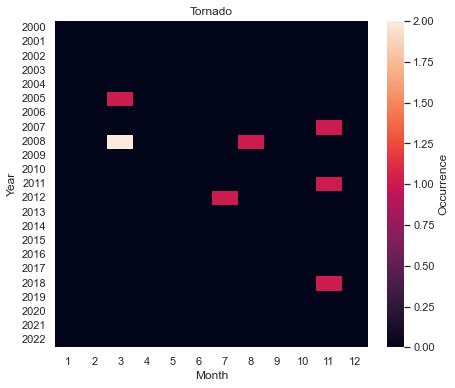

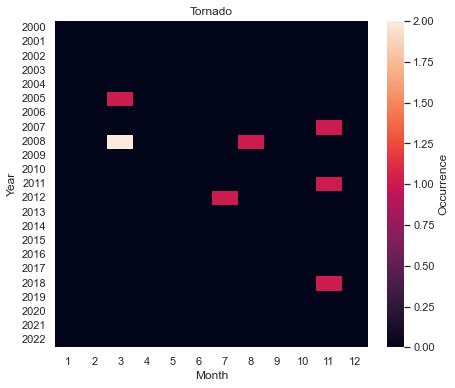

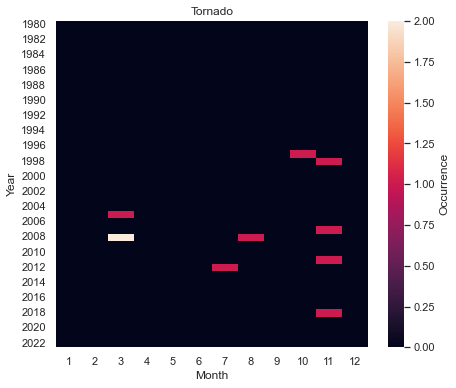

In [19]:
## MONTH, DAY, HOUR
# ret = heatMap(df_new, 'RA', 'HOUR', 1980, 2022)
# ret = heatMap(df_new, 'TS', 'MONTH', 2000, 2022)
# ret = heatMap(df_new, 'FG', 'MONTH', 2000, 2022)
ret = heatMap(df_new, 'FC', 'MONTH', 2000, 2022)

# ret = heatMap(df_new, 'RA', 'DAY', 2000, 2022)
# ret = heatMap(df_new, 'TS', 'DAY', 2000, 2022)
# ret = heatMap(df_new, 'FG', 'DAY', 2000, 2022)
ret = heatMap(df_new, 'FC', 'DAY', 2000, 2022)


# ret = heatMap(df_new, 'RA', 'MONTH', 1980, 2022)
# ret = heatMap(df_new, 'TS', 'MONTH', 1980, 2022)
# ret = heatMap(df_new, 'FG', 'MONTH', 1980, 2022)
# ret = heatMap(df_new, 'FC', 'MONTH', 1980, 2022)

# Features Affecting the Weather the Most

In [56]:
df.shape

(4105808, 17)

In [76]:
df_new[df_new['WND_angle'] == 99]

,STATION,DATE,DATE_year,DATE_month,DATE_day,DATE_hour,WND_angle,WND_speed,CIG_ceiling_height,VIS_distance,TMP_temp_celsius,DEW_temp_celsius,SLP_hectopascal,AT1,AT2,AT3,AT4


In [22]:
from sklearn.ensemble import ExtraTreesClassifier


def importanceLevel(df):
    df_copy = df.copy(deep=True)
    df_copy = df_copy.drop(['DATE', 'DATE_day', 'DATE_hour', 'STATION', 'AT2', 'AT3', 'AT4'], axis = 1)
    print(df_copy.shape)
    
    df_copy['AT1'] = df_copy.AT1.str[3:5]

    df_copy = df_copy.reset_index(drop=True)
    
    nanIdx = df_copy[df_copy['AT1'].isna()]['AT1'].index.values


    df_copy.loc[nanIdx, 'AT1'] = 0

    print(uniqueElementPd(df_copy['AT1']))

    


    x = df_copy.drop('AT1', axis = 1)
    y = df_copy['AT1']

    model = ExtraTreesClassifier()
    model.fit(x.astype('int'), y.astype('int'))

    feat_importances = pd.Series(model.feature_importances_, index=x.columns)

    plt.figure(figsize=(6, 6))

    feat_importances.nlargest(13).plot(kind='barh')

    return 0

(3310223, 10)
[0, '01', '16', '13', '03', '08', '17', '18', '22', '21', '19', '14', '07', '10', '15', '05', '04']


0

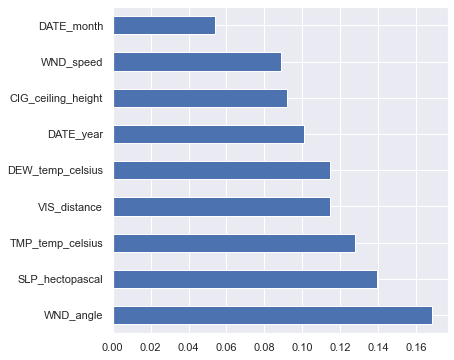

In [23]:
## Takes about 2 min
## what features affect weather the most
importanceLevel(df_new)

# Bad Weather Annual Count

In [109]:
def weatherCount(df, weather, startYear, endYear):

    df_copy = df[['STATION', 'DATE_year', 'DATE_month', 'DATE_day', 'AT1', 'AT2', 'AT3', 'AT4']].copy(deep=True)
    df_copy = df_copy[(df_copy['DATE_year'] >= startYear) & (df_copy['DATE_year'] <= endYear)]
    df_copy['AT1'] = df_copy.AT1.str[6:10]
    df_copy['AT1'] = df_copy['AT1'].str.strip()
    df_copy['AT2'] = df_copy.AT2.str[6:10]
    df_copy['AT2'] = df_copy['AT2'].str.strip()
    df_copy['AT3'] = df_copy.AT3.str[6:10]
    df_copy['AT3'] = df_copy['AT3'].str.strip()
    df_copy['AT4'] = df_copy.AT4.str[6:10]
    df_copy['AT4'] = df_copy['AT4'].str.strip()

    df_copy = df_copy.drop_duplicates()

    temp = df_copy[df_copy['AT1'] == weather]
    # print(np.shape(temp))
    temp = pd.concat([temp, df_copy[df_copy['AT2'] == weather]])
    # print(np.shape(temp))
    temp = pd.concat([temp, df_copy[df_copy['AT3'] == weather]])
    # print(np.shape(temp))
    temp = pd.concat([temp, df_copy[df_copy['AT4'] == weather]])
    # print(np.shape(temp))
    # print(temp.head())


    yearRange = endYear - startYear

    weatherCountNp = np.zeros([yearRange+1, 12, 1])
    # print(np.shape(weatherCountNp))

    for i in range(len(temp)):
        # print(temp.iloc[i]['DATE_year'], temp.iloc[i]['DATE_month'])
        # print(temp.iloc[i]['DATE_year']-startYear-1, temp.iloc[i]['DATE_month']-1)
        # print()
        weatherCountNp[temp.iloc[i]['DATE_year']-startYear, temp.iloc[i]['DATE_month']-1, 0] += 1

    # print(weatherCountNp)
    
    plt.figure(figsize=(8, 8))
    x = [k+1 for k in range(12)]
    y = []
    
    for i in range(yearRange+1):
        # print(i)
        for j in range(12):
            y.append(weatherCountNp[i, j, 0])
        if endYear == 2022 and i == yearRange:
            plt.plot(x, y, '-*', color='red')
        else:
            plt.plot(x, y, linestyle = '--')

        y = []

    std = np.std(weatherCountNp[:-1], axis=0)
    avg = np.mean(weatherCountNp[:-1], axis=0)
    # print('std: ', std)
    
    plt.plot(x, avg, 'k-', linewidth = 4)
    plt.plot(x, avg-std, 'k--', linewidth=3)
    plt.plot(x, avg+std, 'k--', linewidth=3)
    
    legendList = [str(k+startYear) for k in range(yearRange+1)]
    legendList.append('Mean')
    legendList.append('Std')
    plt.legend(legendList, bbox_to_anchor=(1.04, 0.5), loc='center left', fontsize=14)
    plt.title(convertWeatherAbbreviation(weather), fontsize=24)
    plt.xlabel('Month', fontsize=20)
    plt.ylabel('Occurrence', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.grid(True)
    # plt.tight_layout()
    plt.show()
    return 0


In [110]:
weatherCount(df, 'RA', 2000, 2022)
weatherCount(df, 'TS', 2000, 2022)
weatherCount(df, 'FG', 2000, 2022)
weatherCount(df, 'FC', 2000, 2022)



# Contour Map